# Vector Graphics

In [2]:
# Settings and imports.
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import count
from math import sqrt, pi, sin, cos, atan, radians, degrees
from random import random
from time import time
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import Turtle, VectorImage

-----

# A) Turtle Graphics

See `drawing.py` for the implementation of the Turtle.

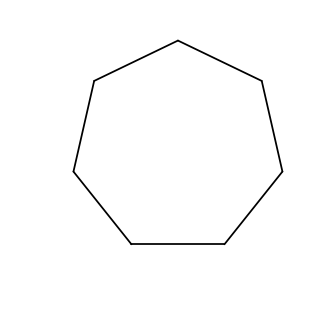

In [5]:
def polygon(turtle, n, a=1):
    for i in range(n):
        turtle.forward(a)
        turtle.left(360 / n)
    return turtle
           
polygon(Turtle(), 7).show()

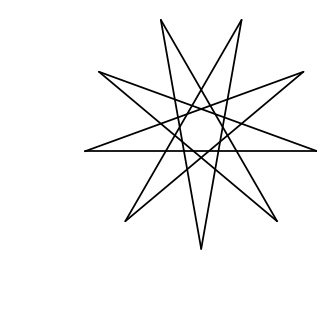

In [6]:
def star(turtle, n, skip, a=1):
    for i in range(n):
        turtle.forward(a)
        turtle.left(360 * skip / n)
    return turtle
           
star(Turtle(), 9, 4).show()

-----

# B) Relative vs. Absolute Drawing

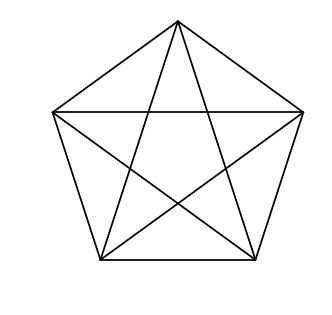

In [7]:
def pentagon_rel():
    turtle = Turtle()
    polygon(turtle, 5)
    turtle.left(360/10)
    length = 2 * sin((pi - 2*pi / 5)/2)  # TODO: simplify + use radians
    star(turtle, 5, 2, length)
    turtle.show()
    
pentagon_rel()

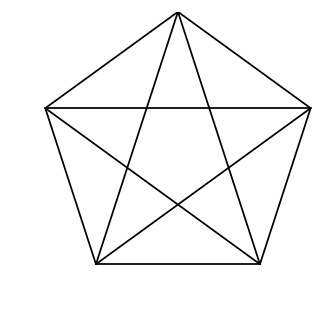

In [8]:
def pentagon_abs():
    im = VectorImage()
    angles = [radians(90 + i * 360/5) for i in range(5)]
    vertices = [(cos(angle), sin(angle)) for angle in angles]
    for i in range(5):
        im.line(vertices[i], vertices[(i+1) % 5])
        im.line(vertices[i], vertices[(i+2) % 5])
    
pentagon_abs()

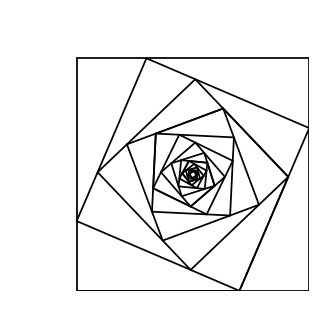

In [9]:
# Relative drawing
def nested_squares(n, length=1, shift=0.7):
    turtle = Turtle()
    angle = degrees(atan(shift/(1-shift)))
    for i in range(n):
        polygon(turtle, 4, a=length)
        turtle.forward(shift * length)
        turtle.left(angle)
        length = shift * length / sin(radians(angle))       
    turtle.show()

nested_squares(15)

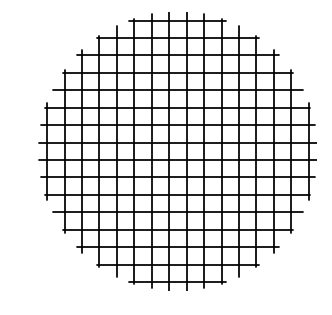

In [10]:
# Absolute drawing
def grid_circle(n_lines=16, radius=1):
    im = VectorImage()
    step = 2 * radius / (n_lines - 1)
    mid_line = (n_lines - 1) / 2
    for i in range(n_lines):
        dist1 = radius * 2 * (i - mid_line) / n_lines
        dist2 = sqrt(radius**2 - dist1**2) 
        im.line([-dist2, dist1], [dist2, dist1])
        im.line([dist1, -dist2], [dist1, dist2])   
    
grid_circle()

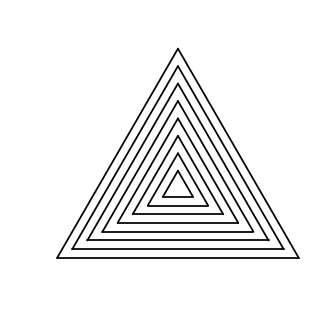

In [11]:
# Absolute drawing
def centered_equilateral_triangle(im, length):
    angles = [radians(90 + i * 120) for i in range(3)]
    vertices = [
        (cos(angle) * length, sin(angle) * length)
        for angle in angles]
    for i in range(3):
        im.line(vertices[i], vertices[(i+1) % 3])
    
def nested_triangles(n=8, length=1):
    im = VectorImage()
    for i in range(n+1):
        centered_equilateral_triangle(im, length * i / n)        

nested_triangles()

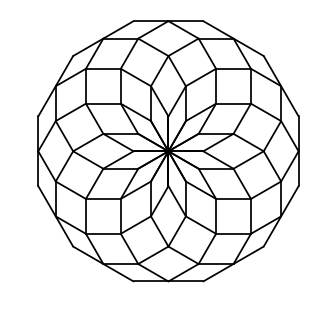

In [12]:
# Relative drawing
def multipolygon(n, length=1):
    turtle = Turtle()
    angle = 360 / n
    for i in range(n):
        polygon(turtle, n, a=length)
        turtle.left(angle)     
    turtle.show()

multipolygon(12)

-----

# C) Fractals

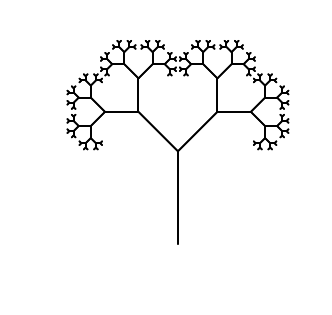

In [13]:
def tree_rec(turtle, n, length=1, shrinking=0.6):
    if n == 0:
        return turtle
    turtle.forward(length)
    turtle.left(45)
    tree_rec(turtle, n-1, length * shrinking)
    turtle.right(90)
    tree_rec(turtle, n-1, length * shrinking)
    turtle.left(45)
    turtle.back(length)
    return turtle

def tree(n=8):
    turtle = Turtle()
    turtle.left(90)
    turtle = tree_rec(turtle, n)
    turtle.show()

tree()

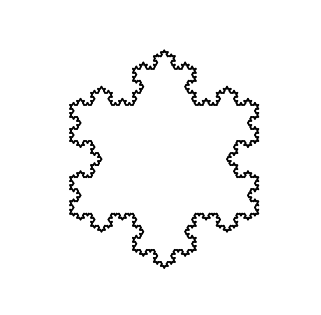

In [18]:
def koch_line(turtle, n, length=1):
    if n == 0:
        turtle.forward(length)
        return
    koch_line(turtle, n-1, length)
    turtle.left(60)
    koch_line(turtle, n-1, length)
    turtle.right(120)
    koch_line(turtle, n-1, length)
    turtle.left(60)
    koch_line(turtle, n-1, length)

def koch_flake(n):
    turtle = Turtle()
    for i in range(3):
        koch_line(turtle, n)
        turtle.right(120)
    turtle.show()

koch_flake(n=4)

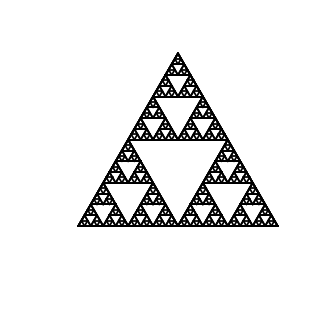

In [26]:
def sierpinski_triangle(n, length=1):   
    def sierpinski_rec(n, length):
        if n == 0:
            return
        for i in range(3):
            sierpinski_rec(n-1, length/2)
            turtle.forward(length)
            turtle.left(120)
    
    turtle = Turtle()
    sierpinski_rec(n, length)
    turtle.show()

dsierpinski_triangle(n=6)

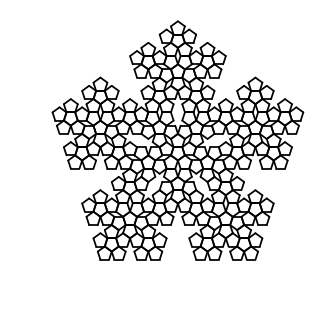

In [48]:
# TODO: Improve readability.
# (Try using center of picturu of the base point? Absolute drawing?)

def pentagon(turtle, length):
    for i in range(5):
        turtle.forward(length)
        turtle.left(360 / 5)
        
def pentagon_flake(n, length=1):   
    def flake_rec(n, length):
        if n == 0:
            #polygon(turtle, n=5, a=length)
            pentagon(turtle, length)
            return
        nested_length = shrinking_ratio * length
        # Outside pentagons.
        for i in range(5):
            flake_rec(n-1, nested_length)
            turtle.penup()
            turtle.forward(length)
            turtle.pendown()
            turtle.left(360/5)
        # Inside pentagon: get to its corner, it, get back.
        turtle.penup()
        turtle.forward(nested_length)
        turtle.left(360/5)        
        turtle.forward(nested_length)
        angle = 180 - 108 - 36
        turtle.right(angle)
        turtle.pendown()
        flake_rec(n-1, nested_length)
        turtle.penup()
        turtle.left(angle)
        turtle.back(nested_length)
        turtle.right(360/5)        
        turtle.back(nested_length)
        turtle.pendown()
    
    turtle = Turtle()
    shrinking_ratio = 1 / (2 * (1 + sin(radians(18))))
    flake_rec(n, length)
    turtle.show()

pentagon_flake(n=3)

-----

# D) Creative Turlte

TODO